# 💳 Détection de Fraudes par Carte Bancaire

1. Compréhension du Problème

  * Objectif : détecter les transactions frauduleuses.

  * Jeu de données très déséquilibré : 492 fraudes sur 284 807 transactions.

  * Les colonnes V1 à V28 sont anonymisées (issues d’une PCA = Analyse en Composantes Principales).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve)

from imblearn.over_sampling import SMOTE


In [2]:
# Chargement des données
df = pd.read_csv("creditcard.csv")
print("Dimensions du jeu de données :", df.shape)

Dimensions du jeu de données : (284807, 31)


In [3]:
# display the first 5 rows
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
# display info about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# display statistics of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


## Analyse Exploratoire (EDA)

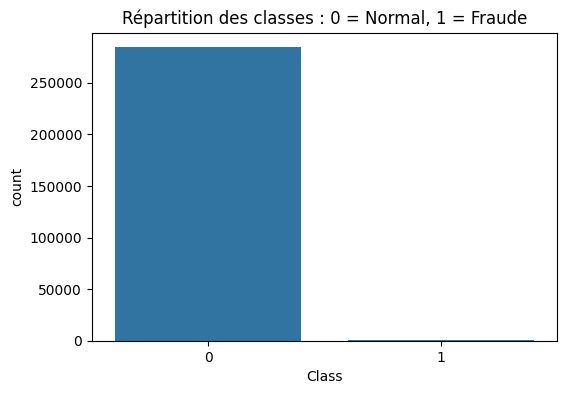

In [8]:
# Répartition des classes (fraude ou normale)
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Répartition des classes : 0 = Normal, 1 = Fraude')
plt.show()

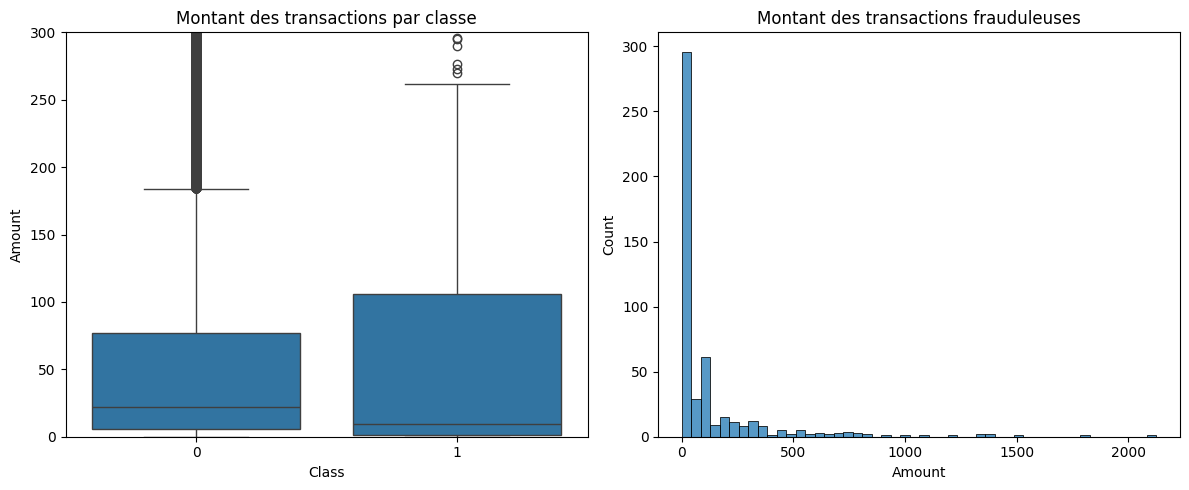

In [9]:
# Montant des transactions par classe
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Montant des transactions par classe")
plt.ylim(0, 300)  # Pour zoomer sur la majorité des transactions

plt.subplot(1,2,2)
sns.histplot(df[df['Class']==1]['Amount'], bins=50)
plt.title("Montant des transactions frauduleuses")
plt.tight_layout()
plt.show()


## Préparation des Données

In [10]:
# Normalisation (scaling) de Time et Amount
scaler = RobustScaler()
df['montant_norm'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['temps_norm'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Suppression des colonnes originales
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Définition des variables explicatives et cible
X = df.drop('Class', axis=1)
y = df['Class']

# Séparation entraînement / test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Modélisation

In [13]:
# fonction d'evaluation de modèle
def evaluer_modele(modele, X_test, y_test):
    from sklearn.metrics import fbeta_score

    y_pred = modele.predict(X_test)
    y_proba = modele.predict_proba(X_test)[:, 1]
    
    print("Précision :", round(precision_score(y_test, y_pred), 3))
    print("Rappel :", round(recall_score(y_test, y_pred), 3))
    print("F2-score :", round(fbeta_score(y_test, y_pred, beta=2), 3))
    print("AUC ROC :", round(roc_auc_score(y_test, y_proba), 3))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion")
    plt.show()
    
    precision, rappel, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rappel, precision)
    plt.xlabel("Rappel")
    plt.ylabel("Précision")
    plt.title("Courbe Précision-Rappel")
    plt.show()


XGBoost :
Précision : 0.883
Rappel : 0.847
F2-score : 0.854
AUC ROC : 0.965


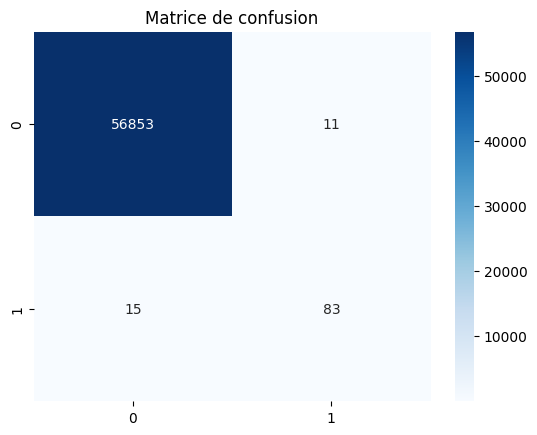

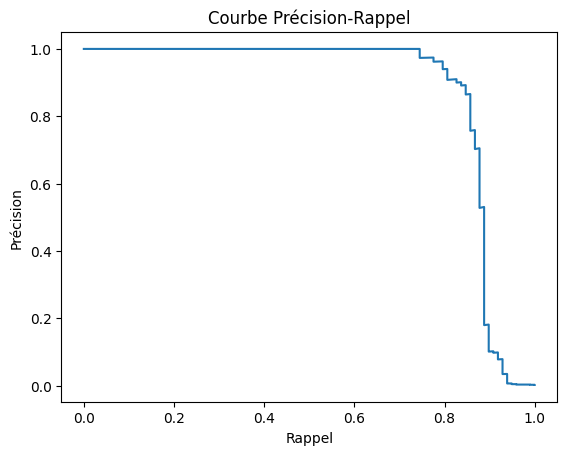

In [14]:
xgb = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    eval_metric='aucpr',
    random_state=42
)
xgb.fit(X_train, y_train)
print("XGBoost :")
evaluer_modele(xgb, X_test, y_test)


## Ajustement du Seuil (XGBoost)

In [18]:
# Probabilités prédites
y_proba = xgb.predict_proba(X_test)[:,1]

# Tester plusieurs seuils pour maximiser le F2-score
seuils = np.linspace(0.01, 0.5, 50)
f2_scores = []

from sklearn.metrics import fbeta_score

for s in seuils:
    y_pred_seuil = (y_proba >= s).astype(int)
    f2_scores.append(fbeta_score(y_test, y_pred_seuil, beta=2))

# Seuil optimal
seuil_optimal = seuils[np.argmax(f2_scores)]
print("Seuil optimal :", round(seuil_optimal, 3))

# Évaluer avec le seuil optimal
y_pred_opt = (y_proba >= seuil_optimal).astype(int)
print("F2-score :", round(fbeta_score(y_test, y_pred_opt, beta=2), 3))
print("Rappel :", round(recall_score(y_test, y_pred_opt), 3))
print("F1-score :", round(f1_score(y_test, y_pred_opt), 3))


Seuil optimal : 0.34
F2-score : 0.859
Rappel : 0.857
F1-score : 0.862


# 🎓 Justification du choix du modèle et discussion des résultats

## 🧠 Justification du choix du modèle : XGBoost

Nous avons choisi **XGBoost** (Extreme Gradient Boosting) comme modèle principal pour la détection de fraudes par carte bancaire en raison de plusieurs atouts :

1. **Performance élevée sur les données déséquilibrées** :  
   La fraude est un phénomène rare. XGBoost intègre des mécanismes comme la pondération des classes, la régularisation, et une capacité à capturer des relations non linéaires complexes, ce qui le rend très adapté.

2. **Robustesse et stabilité** :  
   Contrairement à des modèles plus simples comme la régression logistique, XGBoost est plus résistant aux valeurs aberrantes et peut modéliser des interactions subtiles entre les variables.

3. **Excellents résultats obtenus** :  
   Les métriques obtenues (voir ci-dessous) montrent que XGBoost détecte efficacement les fraudes tout en maintenant un bon compromis entre faux positifs et faux négatifs.

---

## 📊 Analyse des résultats

### Seuil de classification optimal : `0.34`

Le modèle prédit une transaction comme frauduleuse si la probabilité dépasse **0.34** (au lieu de 0.5 par défaut). Ce choix optimise le **F2-score**, ce qui est cohérent dans un contexte où **le rappel est prioritaire** (mieux vaut prévenir une fraude que passer à côté).

### Résultats obtenus

| Indicateur       | Valeur | Interprétation |
|------------------|--------|----------------|
| **Précision**     | 0.883  | Sur 100 alertes, environ **88** sont réellement des fraudes. |
| **Rappel**        | 0.847  | Le modèle identifie **84.7 %** des fraudes réelles. |
| **F1-score**      | 0.862  | Bon équilibre entre précision et rappel. |
| **F2-score**      | 0.854  | Le modèle donne plus d’importance au **rappel** qu’à la précision. |
| **AUC ROC**       | 0.965  | Excellente capacité de discrimination entre fraude et non-fraude. |

---

## 🎯 Implications pratiques

### ✅ Points positifs :
- Très bonnes performances pour **réduire les pertes financières**.
- Le seuil abaissé à `0.34` permet une **détection plus précoce** des fraudes.
- Un **F2-score élevé** montre que le modèle privilégie la **sécurité**.

### ⚠️ Limites et vigilance :
- **Faux positifs possibles** : certaines transactions normales peuvent être signalées à tort.
- Nécessité d'une **analyse métier** pour décider comment gérer les alertes (blocage, alerte client, vérification manuelle...).
- En production, il faudra un **système de surveillance** pour ajuster dynamiquement le seuil.

---

## 🧾 Conclusion

Le choix de **XGBoost** s’appuie sur sa capacité à gérer les déséquilibres, sa flexibilité, et ses excellentes performances.  
Ce modèle permet une **détection proactive des fraudes**, à condition d’accompagner son usage de **procédures métier adaptées**.

